# Keltner Channel Strategy

In [46]:
from datetime import datetime, timedelta
import logging

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
from talib import ATR, EMA, RSI

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level

set_log_level(logging.DEBUG)

In [47]:
class KeltnerChannelBacktester(EventBacktester):
    """
    Backtester that uses the Keltner Channel to make decisions.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        self.keltner_channel_period = 21

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """

        split_bars = separate_bars_by_symbol(bars)
        self.middle_bands = {symbol: EMA(
            split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}
        self.upper_bands = {symbol: self.middle_bands[symbol] + 2 * ATR(split_bars[symbol].loc[:, "high"], split_bars[symbol].loc[:, "low"],
                                                                        split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}
        self.lower_bands = {symbol: self.middle_bands[symbol] - 2 * ATR(split_bars[symbol].loc[:, "high"], split_bars[symbol].loc[:, "low"],
                                                                        split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        split_bars = separate_bars_by_symbol(bars)
        self.middle_bands = {symbol: EMA(
            split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}
        self.upper_bands = {symbol: self.middle_bands[symbol] + 2 * ATR(split_bars[symbol].loc[:, "high"], split_bars[symbol].loc[:, "low"],
                                                                        split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}
        self.lower_bands = {symbol: self.middle_bands[symbol] - 2 * ATR(split_bars[symbol].loc[:, "high"], split_bars[symbol].loc[:, "low"],
                                                                        split_bars[symbol].loc[:, "close"], timeperiod=self.keltner_channel_period) for symbol in self.active_symbols}

    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        orders = []
        for symbol in self.active_symbols:
            quantity = round(200 / close_prices[symbol], 4)
            if close_prices[symbol] > self.upper_bands[symbol][index]:
                orders.append(Order(symbol, Position.SHORT,
                              close_prices[symbol], quantity))
            elif close_prices[symbol] < self.lower_bands[symbol][index]:
                orders.append(Order(symbol, Position.LONG,
                              close_prices[symbol], quantity))

        return orders

In [ ]:
symbols = ["DUK", "DTE"]

bars = download_bars(
    symbols,
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2025, 7, 15),
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.7)

# create the backtester
backtester = KeltnerChannelBacktester(
    symbols,
    cash=2000,
    allow_short=True,
    min_cash_balance=100,
    max_short_value=2000,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.000,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)

# plot the order and state history
print(dash("order history"))
print(backtester.get_history())
print(dash("state history"))
print(backtester.get_state_history())

[2025-08-10 13:49:11][DEBUG] Loading data/DUKDTE_2024-01-01_2025-07-15_1Hour.pkl
[2025-08-10 13:49:11][DEBUG] Initializing backtester with active symbols: ['DUK', 'DTE'], cash: 2000, allow_short: True, min_cash_balance: 100, max_short_value: 2000, min_trade_value: 1, market_hours_only: True
[2025-08-10 13:49:11][INFO] No test bars have been provided. Using train bars for backtest...
[2025-08-10 13:49:11][INFO] Running backtest over 18792 bars from 2024-01-02 09:00:00-05:00 to 2025-01-27 20:00:00-05:00...
[2025-08-10 13:49:11][DEBUG] Placing LONG 1.902 DTE @ $105.150 (2024-01-03 10:00:00-05:00)
[2025-08-10 13:49:11][DEBUG] Placing SHORT 2.1545 DUK @ $92.830 (2024-01-03 11:00:00-05:00)
[2025-08-10 13:49:11][DEBUG] Placing LONG 1.899 DTE @ $105.320 (2024-01-03 11:00:00-05:00)
[2025-08-10 13:49:11][DEBUG] Placing LONG 1.9024 DTE @ $105.130 (2024-01-03 12:00:00-05:00)
[2025-08-10 13:49:11][DEBUG] Placing SHORT 2.1508 DUK @ $92.990 (2024-01-03 13:00:00-05:00)
[2025-08-10 13:49:11][DEBUG] Pla

- order history ----------------------------------------------------------------
                          symbol  position   price  quantity
2024-01-03 10:00:00-05:00    DTE         1  105.15    1.9020
2024-01-03 11:00:00-05:00    DUK        -1   92.83    2.1545
2024-01-03 11:00:00-05:00    DTE         1  105.32    1.8990
2024-01-03 12:00:00-05:00    DTE         1  105.13    1.9024
2024-01-03 13:00:00-05:00    DUK        -1   92.99    2.1508
...                          ...       ...     ...       ...
2025-01-27 14:00:00-05:00    DTE        -1  119.54    1.6731
2025-01-27 15:00:00-05:00    DUK        -1  110.58    1.8086
2025-01-27 15:00:00-05:00    DTE        -1  119.79    1.6696
2025-01-27 16:00:00-05:00    DUK        -1  110.58    2.1622
2025-01-27 16:00:00-05:00    DTE         1  119.78   10.0820

[1186 rows x 4 columns]
- state history ----------------------------------------------------------------
                                  cash  portfolio_value     DUK      DTE
0       

In [49]:
# plot the performance
print(dash("performance"))
print(backtester.pretty_format_performance())

- performance ------------------------------------------------------------------


Backtest Performance:
- Return on Investment: 9.59%
- vs. Buy and Hold Return: 16.47%
- Sharpe Ratio: 0.10
- Max Drawdown Percentage: 11.63%

- Start Portfolio Value: $2000.00
- End Portfolio Value: $2191.74
- Min Portfolio Value: $1899.19
- Max Portfolio Value: $2290.20
- Min Cash Balance: $0.00
- Max Cash Balance: $4376.56
- Win Rate: 60.47%

- Number of Orders: 1186
- Number of Winning Trades: 716
- Number of Losing Trades: 468
- Avg Trade Return: 0.38%
- Largest Win: 12.55% ($16.65)
- Largest Loss: -7.75% ($-12.23)
- Max Consecutive Wins: 85
- Max Consecutive Losses: 1

- Trading Period Start: 2024-01-02 09:00:00-05:00
- Trading Period End: 2025-01-27 16:00:00-05:00
- Trading Period Length: 391 days 07:00:00
- Time in Market: 99.71%


plotting...


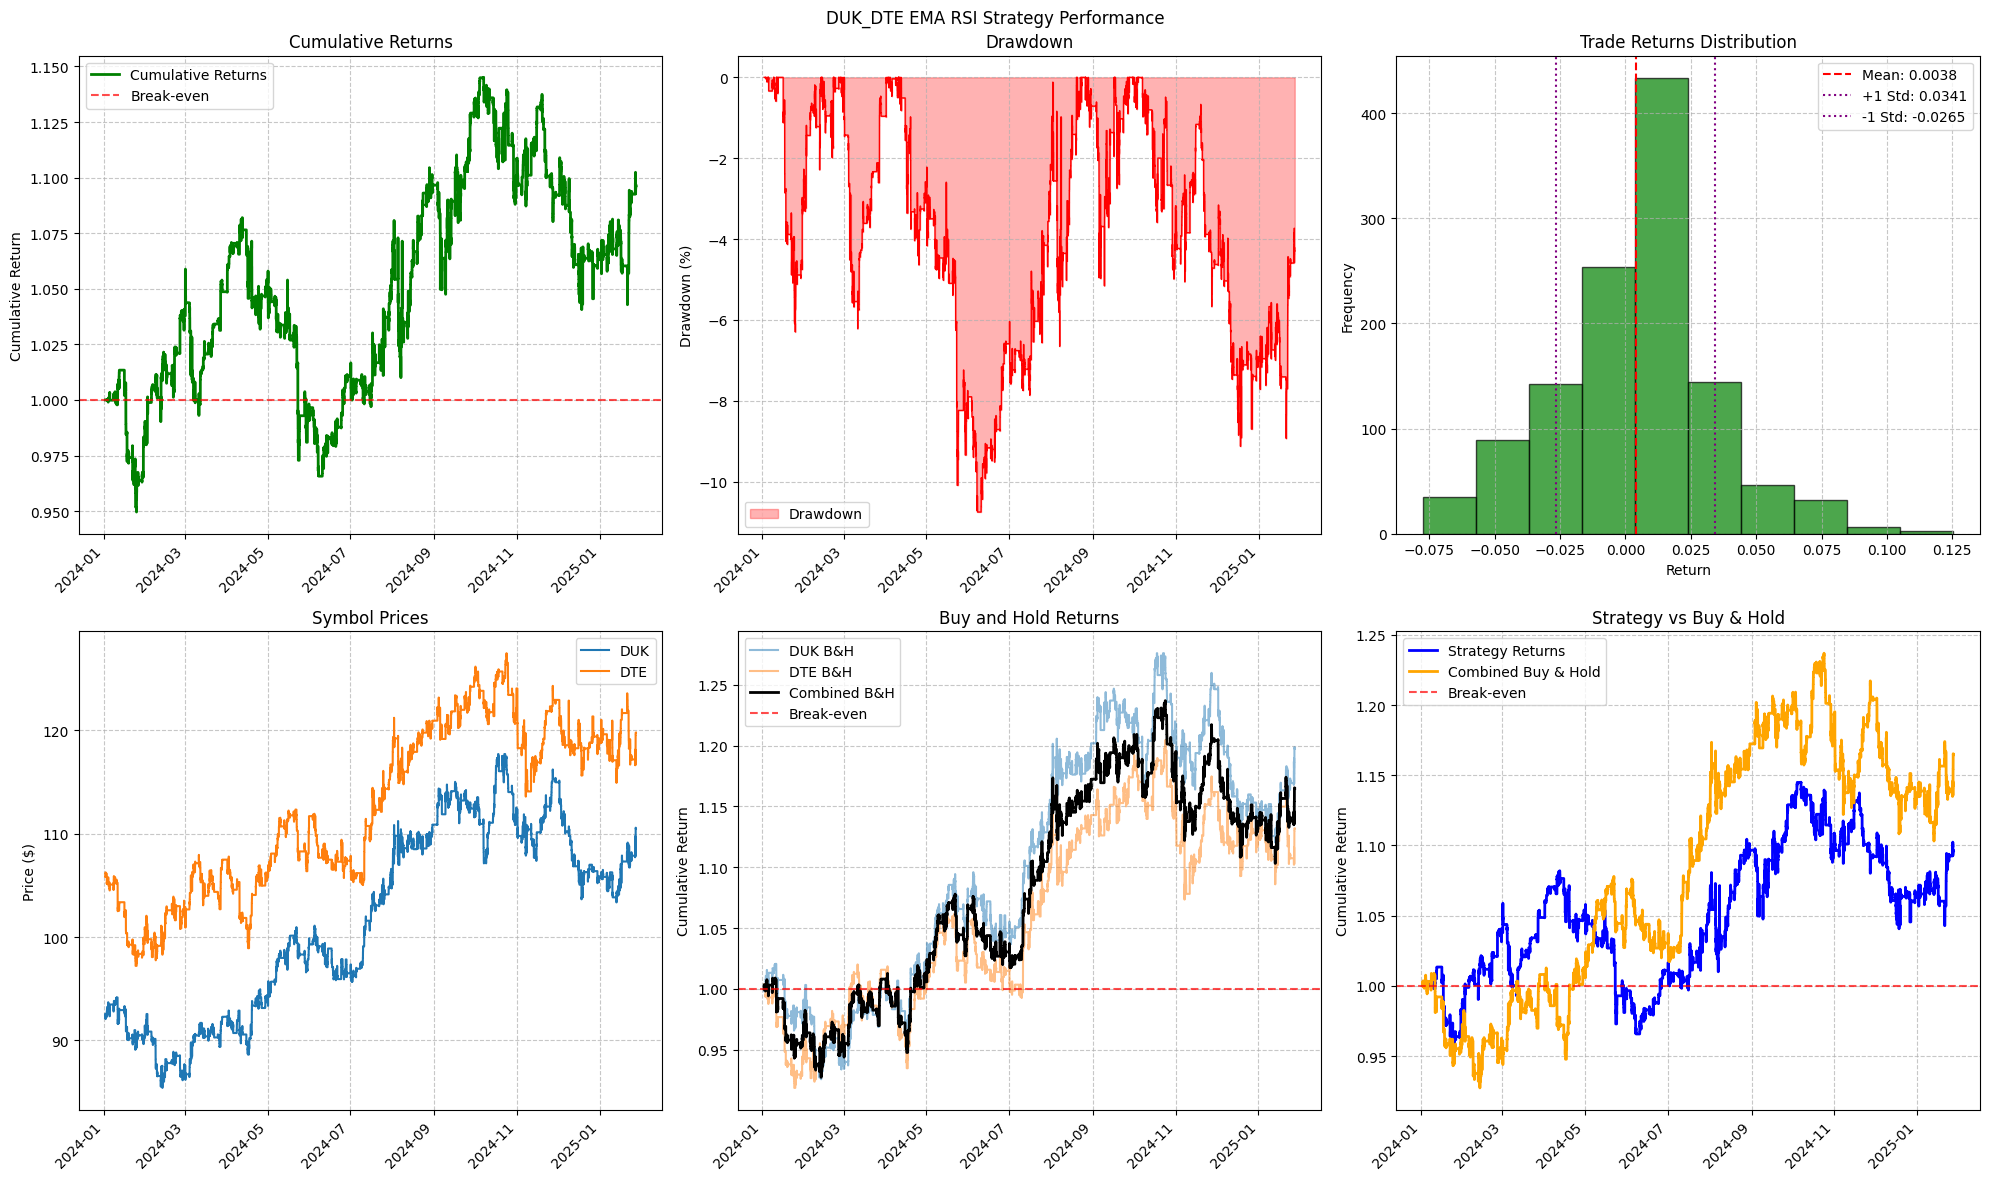

In [50]:
# Plot the results
print("plotting...")
backtester.plot_performance_analysis(
    title="_".join(symbols) + " EMA RSI Strategy Performance", show_plot=False)

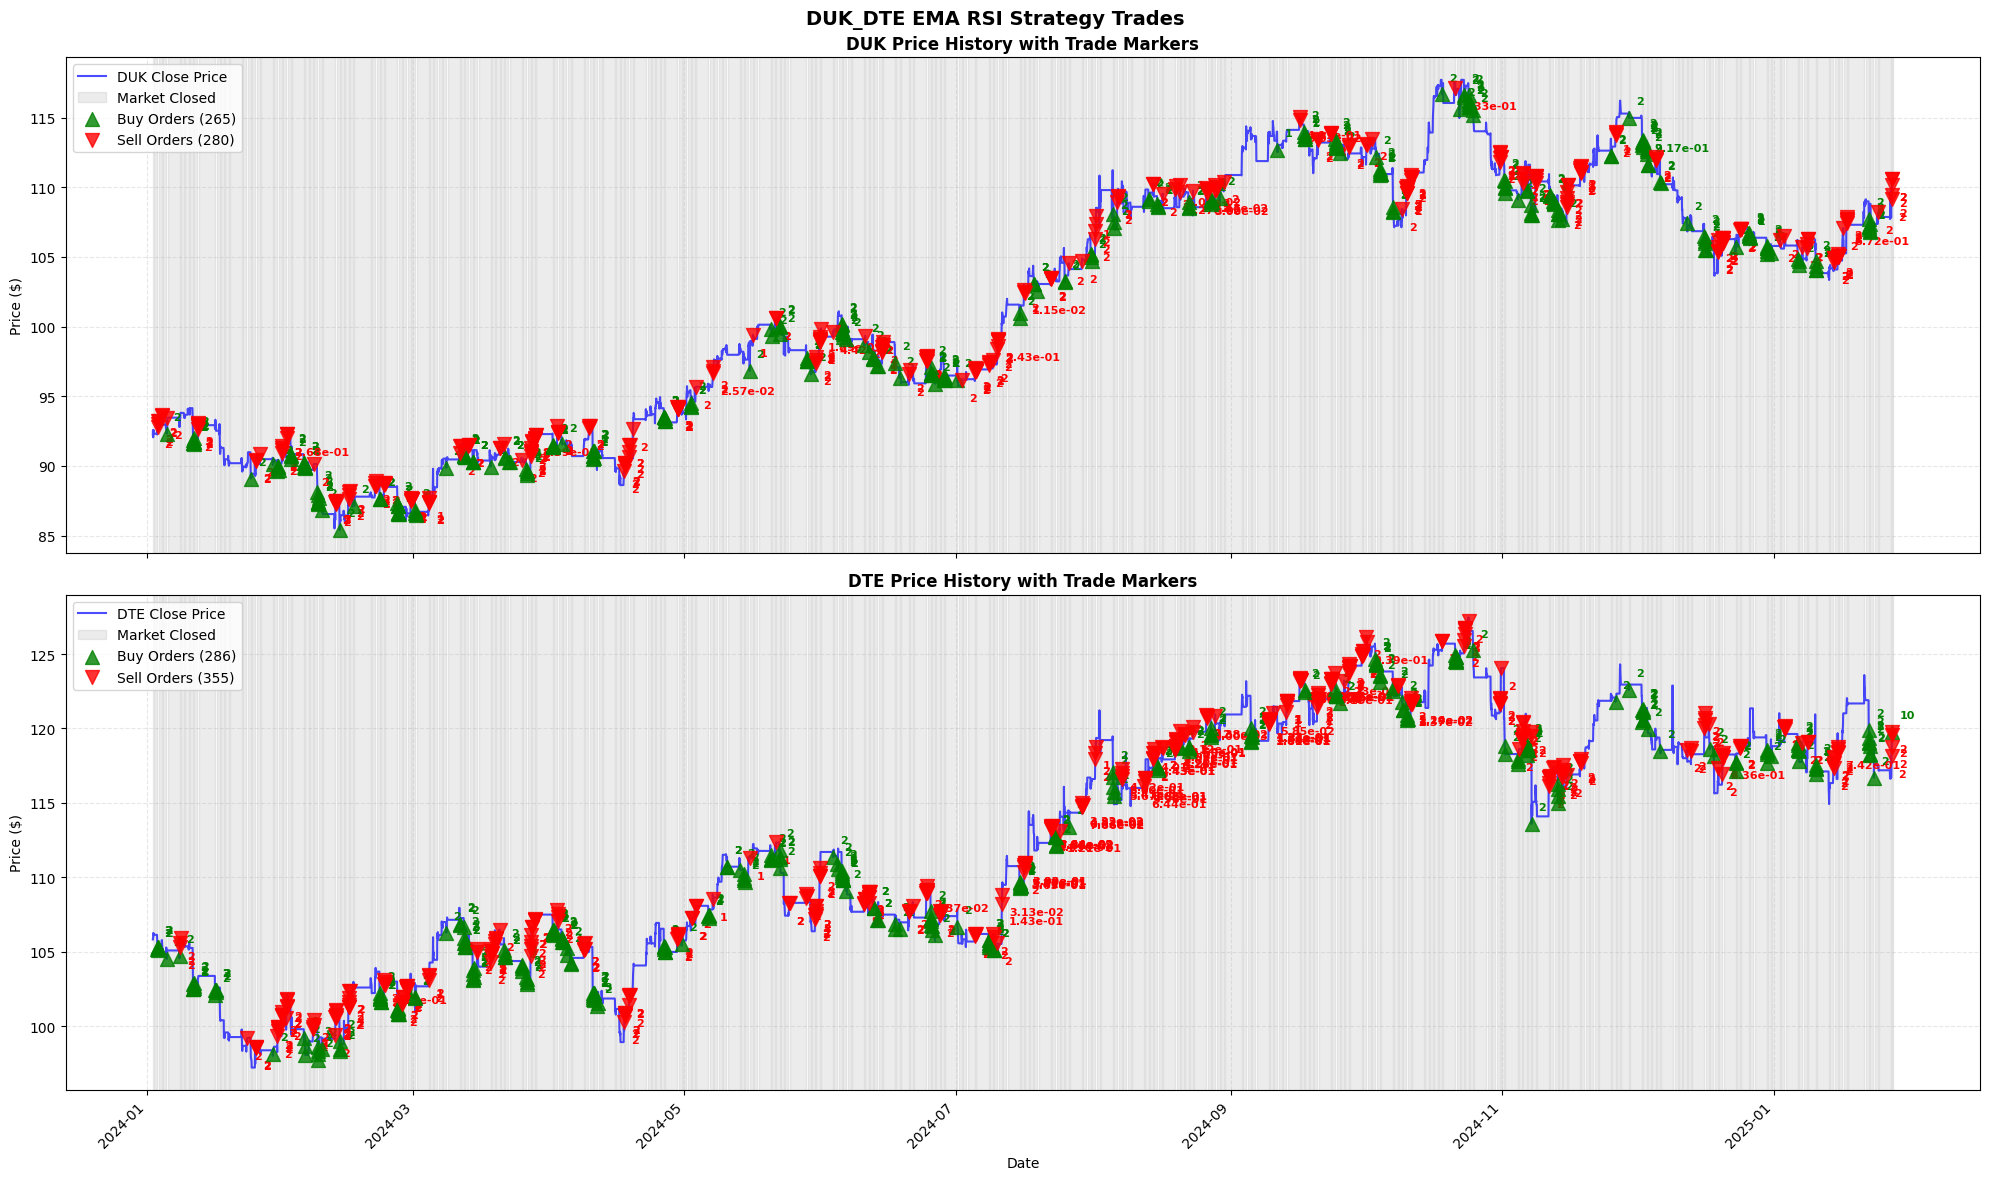

In [51]:
backtester.plot_trade_history(title="_".join(
    symbols) + " EMA RSI Strategy Trades", show_plot=False)

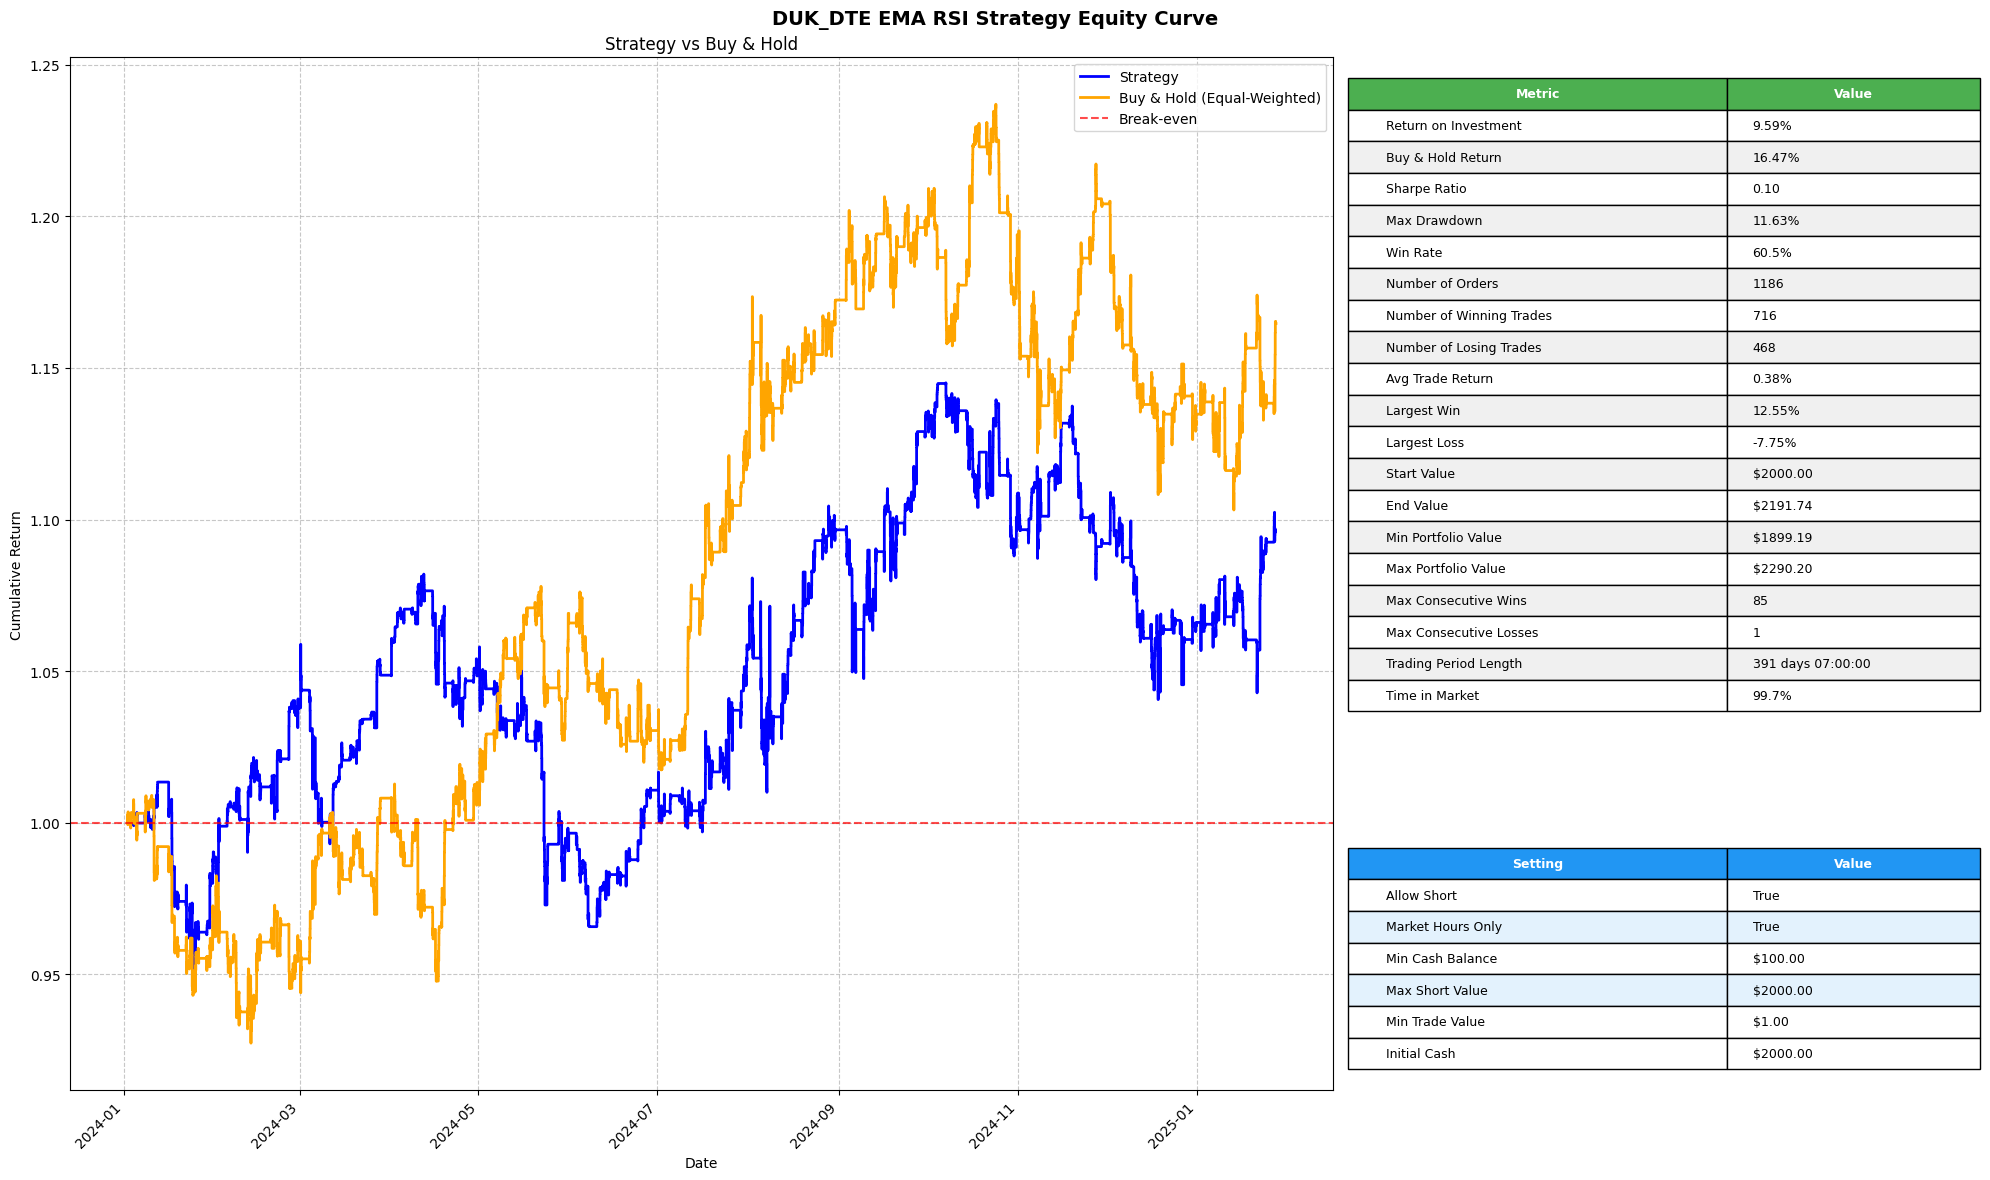

In [52]:
backtester.plot_equity_curve(
    title="_".join(symbols) + " EMA RSI Strategy Equity Curve", show_plot=False
)